# Explore forum posts
How many words per post, how many posts per author, that sort of thing.  Intended to help inform the design of our authorship attribution models.  Note that we are including only posts with at least some text (_selftext_) and ignoring posts that are just an image/url.

In [1]:
import json
lines = open('../data/RS_2011-01', "r").readlines()
posts = []

i = 0
while len(posts) < 1000000 and i < len(lines):
    try:
        i = i + 1
        p = json.loads(lines[i-1].rstrip())
        
        # Keep only posts with at least some text
        if len(p['selftext']) == 0:
            continue
            
        posts.append(p)
    except:
        continue
        
print("Loaded " + str(len(posts)) + " posts.")
print("Sample post:")
posts[9]['selftext']

Loaded 178883 posts.
Sample post:


"I'd rather not download a torrent if at all possible. I've been looking on LetMeWatchThis.com, ch131.com, and alluc.org for months now. Nobody seems to have it. \n\nThanks if you can help."

In [2]:
posts[9].keys()

dict_keys(['downs', 'link_flair_text', 'distinguished', 'media', 'url', 'link_flair_css_class', 'id', 'edited', 'num_reports', 'created_utc', 'banned_by', 'name', 'subreddit', 'title', 'author_flair_text', 'is_self', 'author', 'media_embed', 'permalink', 'author_flair_css_class', 'selftext', 'domain', 'num_comments', 'likes', 'clicked', 'thumbnail', 'saved', 'subreddit_id', 'ups', 'approved_by', 'score', 'selftext_html', 'created', 'hidden', 'over_18'])

## Words per post?
This might affect our opinions about the size of the sequences we need to work with.

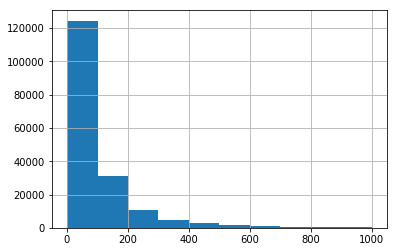

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

counts = []
for p in posts:
    counts.append(len(p['selftext'].split(" ")))
    
df = pd.DataFrame({"counts": counts})
df['counts'][df['counts'] < 1000].hist()

## How prolific?
How many posts from the typical author?

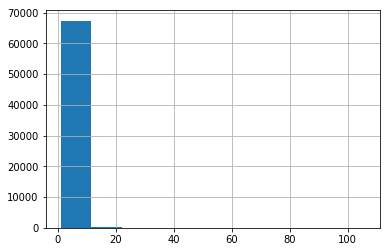

In [5]:
author_counts = dict()
for p in posts:
    if 'author' not in p:
        continue
        
    if p['author'] == '[deleted]':
        continue
        
    if p['author'] not in author_counts:
        author_counts[p['author']] = 1
    else:
        author_counts[p['author']] = author_counts[p['author']] + 1
        
df_authors = pd.DataFrame({'author': list(author_counts.keys()), 'posts': list(author_counts.values())})
df_authors.posts.hist()

How many authors?

In [6]:
print(len(df_authors.author.unique()))

67811


How many posts from our top/best-case authors?

In [7]:
df_authors = df_authors.sort_values(by=['posts'])
df_authors.tail()

,author,posts
12957,toofrat,63
1592,recordratus,66
1701,brphollis1,79
623,Moregunsthanpatience,92
2143,rmm45177,106


### And what do their posts look like?
Let's take a per-author look...

In [8]:
target_author = "SwirlStick"
samples = []
for p in posts:
    if 'author' not in p:
        continue
    
    if p['author'] == target_author:
        samples.append(p['selftext'])
    
samples

['Did your mom (bless her heart) just not know how to even boil water, but you had to eat her cooking? Does your wife burn everything? What sort of dishes did they make? What was the worst? Did they think they were any good?',
 "This happens to me a lot. With video games, cartoons, comics, etc. I always remember how awesome they were but then when I try to watch, play, read them again they're kind of lame. Do you have something like this? A food that you enjoyed back then but can't stomach (Kraft mac &amp; cheese with cut up Oscar Meyer hot dogs). A video game (some of the old SNES games), TV shows? Books? Movies? Toys?",
 'What was it? Do you still use it? Have you bought any others for gifts?',
 "I love watching Antiques Roadshow, Pawn Stars, American Picker, Hardcore Pawn, etc. It's always amazing to see what people have sitting in their attics that turns out to be worth a crap load. But it's also as entertaining to see the blokes who think they have something of value and it turns 

## Prepare for training
Strip down to the essentials - text of the post, author name

In [9]:
post_author = []
post_content = []
for p in posts:
    if p['author'] != '[deleted]' and author_counts[p['author']] >= 10:
        post_author.append(p['author'])
        post_content.append(p['selftext'])

df_post_and_author = pd.DataFrame({"author":post_author, "text":post_content})
df_post_and_author.to_csv("../data/sample_author_and_post.csv", index=False)
df_post_and_author.head()

,author,text
0,thenewguy729,So I bought Amnesia on the Steam sale the othe...
1,deathmouse,let's discuss this in detail.\r\n\r\ni'm in th...
2,thomasmcnlt6,"I've just bought a tooth paste key, a little c..."
3,acdev,The articles ([here](http://www.laxmagazine.co...
4,Everseer,Katey says:\n\n i bought a glockenspiel\n\n\nN...


How many samples do we have?

In [10]:
print(df_post_and_author.shape[0])

11104


How many authors in our sample?

In [11]:
print(len(set(df_post_and_author.author)))

740


Words per author?

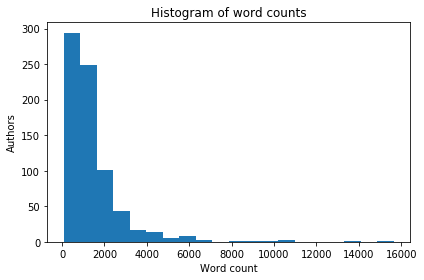

In [12]:
import matplotlib.mlab as mlab

post_word_count = df_post_and_author.text.apply(lambda x: len(x.split(" ")))
df_post_and_author['word_count'] = post_word_count
words_per_author = df_post_and_author.groupby(['author'])['word_count'].sum()

num_bins = 20

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(words_per_author, num_bins)

# add a 'best fit' line
#y = mlab.normpdf(bins)
#ax.plot(bins, y, '--')
ax.set_xlabel('Word count')
ax.set_ylabel('Authors')
ax.set_title(r'Histogram of word counts')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

Now, we prepare our data for easy ingestion by FastAI. Labels should be in the first column, but first we'll replace our author names with a numeric code.

In [21]:
keys = list(set(df_post_and_author.author))
values = list(range(0, len(keys)))
author_to_label = dict(zip(keys, values))
df_post_and_author['label'] = df_post_and_author['author'].apply(lambda x: author_to_label[x])
df_post_and_author.head()                                                               

,author,text,word_count,label
0,thenewguy729,So I bought Amnesia on the Steam sale the othe...,141,645
1,deathmouse,let's discuss this in detail.\r\n\r\ni'm in th...,38,68
2,thomasmcnlt6,"I've just bought a tooth paste key, a little c...",40,417
3,acdev,The articles ([here](http://www.laxmagazine.co...,179,318
4,Everseer,Katey says:\n\n i bought a glockenspiel\n\n\nN...,78,118


In [23]:
df_fastaiformat = pd.DataFrame({'label':df_post_and_author.label, 'text':df_post_and_author.text})
df_fastaiformat.head()

,label,text
0,645,So I bought Amnesia on the Steam sale the othe...
1,68,let's discuss this in detail.\r\n\r\ni'm in th...
2,417,"I've just bought a tooth paste key, a little c..."
3,318,The articles ([here](http://www.laxmagazine.co...
4,118,Katey says:\n\n i bought a glockenspiel\n\n\nN...


In [26]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_fastaiformat.text,df_fastaiformat.label,stratify=df_fastaiformat.label)
df_fai_train = pd.DataFrame({'label' : y_train, 'text' : x_train})
df_fai_test = pd.DataFrame({'label' : y_test, 'text' : x_test})
df_fai_train.head()

,label,text
7860,687,for complete information read at [Forex Weekly...
2302,518,1:1\n\nThanks!\n
935,116,My mother seems to think that by law if you us...
963,95,It seems to me that the republicans are going ...
5170,593,A few rules:\n\n\n\n* Select any **season 10 -...


In [27]:
df_fai_train.to_csv('../data/df_authorship_fastai_train.csv')
df_fai_test.to_csv('../data/df_authorship_fastai_test.csv')